In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal, norm
from tqdm.auto import tqdm

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

There are the results of an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time in the control group 1928 players out of 202103 turned out to be paying players, and in the test group - 1805 out of 202667 players.
Which set of offers can be considered the best? What metrics should be analysed to make the right decision and how to?

Load the data, check it for omissions, unique values, etc.

In [2]:
df = pd.read_csv('/home/jupyter-n.sobolevskaja-14/task_2.csv', sep=';')

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

According to the number of unique users we see that the groups did not overlap with each other, i.e. the principle of independence of samples was observed

In [6]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

Now let's take a closer look at the statistics among both groups in terms of revenue. Let's select only paying users. We can see that in group A the average cheque is smaller than in group B. At the same time, the distribution of figures by percentiles differs very much. In the control group (A) there are large outliers and difference between minimum and maximum values (spread)

In [7]:
df.query('testgroup == "a" & revenue > 0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [8]:
df.query('testgroup == "b" & revenue > 0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Let's make a visualisation of the income distribution in both groups. The visualisation shows a big difference in payment behaviour: in the control group (A) users bought either cheap or extremely expensive promotional offers. In the test group (B) purchases were more ‘monochromatic’ and the difference between the cheapest and the most expensive purchase is small relative to the group A

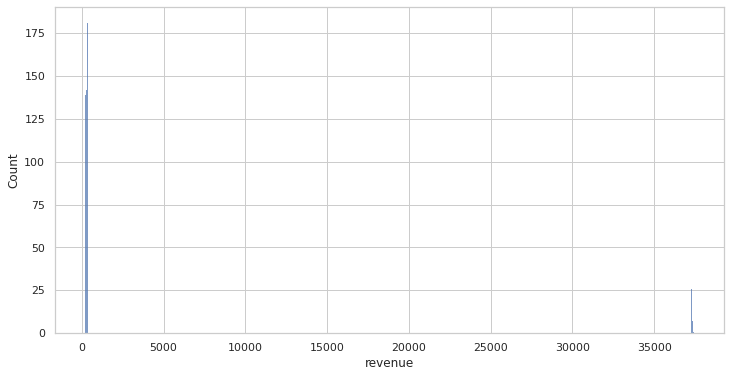

In [9]:
sns.histplot(data = df.query('testgroup == "a" & revenue > 0').revenue)

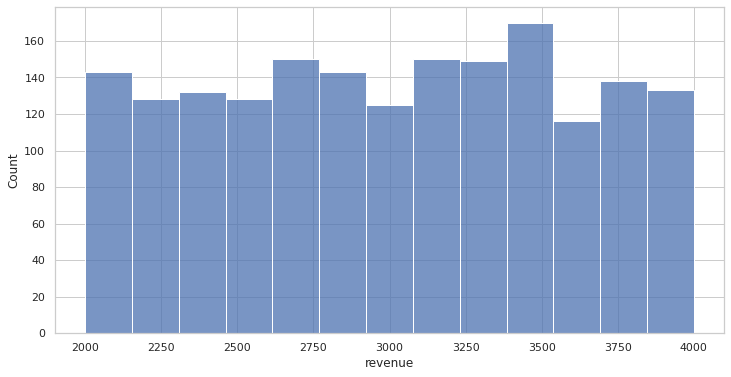

In [10]:
sns.histplot(data = df.query('testgroup == "b" & revenue > 0').revenue)

Now let's compare our averages of the two groups without singling out only paying users. The average in the test group is 5.3% higher than in the control group. That is, this is the ARPU indicator indicated in the task 

In [11]:
df.query('testgroup == "a"').revenue.mean()

25.413719736965806

In [12]:
df.query('testgroup == "b"').revenue.mean()

26.75128659327863

In [13]:
#ARPU
((26.751287/25.413720)-1)*100

5.263168870987789

We add a column with the values: pay/not_pay to the dataset in order to test the hypothesis whether the two groups differ in their willingness to pay for the promotional app

In [14]:
df['purcharse'] = df.revenue.apply(lambda x: 'pay' if x > 0 else 'not_pay')
df.head()

,user_id,revenue,testgroup,purcharse
0,1,0,b,not_pay
1,2,0,a,not_pay
2,3,0,a,not_pay
3,4,0,b,not_pay
4,5,0,b,not_pay


In [15]:
pd.crosstab(df.purcharse, df.testgroup)

testgroup,a,b
purcharse,,
not_pay,200175,200862
pay,1928,1805


To test the assumption, we use the chi-square test since we have two categorical variables

In [16]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.purcharse, df.testgroup))

In [17]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [18]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


According to the test results we see that the null hypothesis is not confirmed. Thus, we can conclude about the influence of the type of promotional offer on the user's willingness to pay. And users from the control group are more willing to pay

Next, we need to understand whether there is a relationship between ARPU (average in income) and the type of promotional offer. To do this, we start by checking the distributions for normality using the Shapiro-Wilk test

In [19]:
A = df.query('testgroup == "a" & revenue > 0')

In [20]:
A_sample = A.revenue.sample(1000)

In [21]:
shapiro(A_sample)

ShapiroResult(statistic=0.26979267597198486, pvalue=0.0)

In [22]:
B = df.query('testgroup == "b" & revenue > 0')

In [23]:
B_sample = B.revenue.sample(1000)

In [24]:
shapiro(B_sample)

ShapiroResult(statistic=0.9593034982681274, pvalue=4.623055004137136e-16)

Since the null hypothesis in the Shapiro-Wilk test is the normality of the distribution, we can conclude that the distributions deviate from normality (as the p-value is less than 0,05)

In [25]:
mannwhitneyu(df.query('testgroup == "a" & revenue > 0').revenue, \
            df.query('testgroup == "b" & revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

We use the Mann-Whitney test because the distributions of the variables deviate from normality. We observe that there are significant differences between the two groups. However, we can draw this conclusion only based on the analysis of medians and cannot make any claims about the mean values (ARPU)

To analyze the difference in mean values, we will perform a bootstrap analysis of the two groups

In [26]:
def get_bootstrap(
    data_column_1, # numerical values of the first sample
    data_column_2, # numerical values of the second sample
    boot_it = 2000, # number of bootstrap subsamples
    statistic = np.mean, # statistics of interest
    bootstrap_conf_level = 0.95 # significance level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

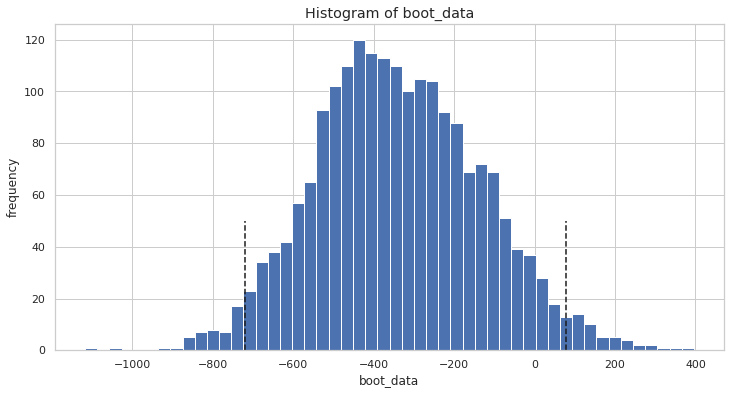

In [27]:
booted_data = get_bootstrap(df.query('testgroup == "a" & revenue > 0').revenue, 
              df.query('testgroup == "b" & revenue > 0').revenue,
              boot_it = 2000)

In [28]:
booted_data["p_value"]

0.10068461260177768

We see that zero falls within the confidence interval of the bootstrap distribution and p-value>0.05, hence we can accept the null hypothesis that there is no statistical difference between the mean values of the checks in the control and test groups

In [29]:
booted_data["ci"]

,0
0.025,-720.763628
0.975,78.929733


As a result of analysing the data, we can draw the following conclusions:

- it can be argued that the promotional app influences users' willingness to pay. There were more paying users in the control group (A)

- the behaviour of paying users in the two groups is very different. In the control group, they buy either cheap offers or very expensive ones. In the test group, on the other hand, purchases are centred around offers with a price range from 2000 to 4000

- after checking the mean values of the two groups we cannot state that they are statistically significantly different, hence the difference in ARPU of 5% with a probability of 95% can be considered random

3. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики для оценки последнего прошедшего события:

- DAU - количество пользователей в приложении в день проведения события.

- отношение DAU/MAU - насколько больше/меньше пользователей заходит в день/дни тематических событий.

- Анализ пользовательской воронки до последнего прошедшего события. То есть, нужно провести анализ по каждому шагу воронки (уровням игры): посмотреть конверсию (CR) в каждый из этапов (абсолютную - от первого шага и относительную - от каждого предыдущего шага).

- Среднее количество пройденных пользователем событий.

- Конверсионное окно - количество времени, за которое пользователь переходит из одного шага в другой.

- Средняя продолжительность сессии (ASL) - среднее арифметическое длин всех сессий (событий).

Изменения в метриках после усложнения механики будут следующими:

- Метрики, оценивающие время прохождения событий (среднее кол-во событий, конверсионное окно, ASL), можно убрать из оценки, так как за счет отката пользователей на болеее низкий уровень их корректность будет сложнее оценить
- В данной случае можно добавить метрику количества откатов пользователей на более низкий уровень и оставить в оценке общее время прохождения от первого уровня до последнего текущего
- Анализ пользовательской воронки и конверсий также стоит делать в данном случае принимая во внимание откаты назад. То есть, переход на следующий уровень  в относительной конверсии не будет означать, что пользователь там и остался до текущего момента. Таким образом, будет показательным значение абсолютной конверсии (от первого шага)